In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [199]:
class NN(tf.Module):
    
    def __init__(self, layers, lb, ub, **kwargs):
        """A dense Neural Net that is specified by layers argument.
        
           layers: input, dense layers and outputs dimensions  
           lb    : An array of minimums of inputs (lower bounds)
           ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)        
        self.lb = lb
        self.ub = ub
        self.build()
        
    def build(self):         
        """Create the state of the layers (weights)"""
        weights = []
        biases = []        
        for l in range(0,self.num_layers-1):
            W = self.xavier_init(size=[self.layers[l], self.layers[l+1]])
            b = tf.Variable(tf.zeros([1,self.layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        
        self.Ws = weights
        self.bs = biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.compat.v1.truncated_normal([in_dim, out_dim], 
                                                         stddev=xavier_stddev, 
                                                         dtype=tf.float32), 
                           dtype=tf.float32)
    
        
    @tf.function
    def __net__(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0*(inputs - self.lb)/(self.ub - self.lb) - 1.0
        for W, b in zip(self.Ws[:-1], self.bs[:-1]):
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
        W = self.Ws[-1]
        b = self.bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        return outputs
    
    def __call__(self, inputs, grads=True):
        """Defines the computation from inputs to outputs
        
        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           grads:  Default 'True'. Returns the first and second 
                   order gradients of the output with respect to 
                   the input when the grads argument is 'True'.
                   
        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
                When 'grads=True', the list of first and second order gradients 
                of the output with respect to the input. 
                
        The returns 'partial_1' and 'partial_2' are the first and second 
        order gradients, repsectivly. Each one is a list that its elements
        corresponds to on of the NN's last layer output. e.g. if the last layer
        has Dn outputs, each list has Dn tensors as an elements. The dimensionality
        of the tensors are the same as inputs: [None, D1]
        
        """
        X = tf.cast(inputs, tf.float32)
        outputs = self.__net__(X)
        if grads:                        
            partials_1 = [tf.gradients(outputs[:,i], X)[0] for i in range(outputs.shape[1])]
            partials_2 = [tf.gradients(partials_1[i], X)[0] for i in range(outputs.shape[1])]
            return outputs, partials_1, partials_2            
        else:            
            return outputs 
        
    def copy(self):
        return copy.deepcopy(self)
    
    
class Loss():
    def __init__(self, pinn, name, data_size = 0, init_loss_weight = 1.0):
        """Loss value that is calulated for the output of the pinn
        
        Args:
            pinn: NN object that will be trained.
            name: The name of the Loss
            data_size: The length of its internal dataset.
            init_loss_weight: Initial weigth of the loss in comparision to others.
            
            
            When the Loss class has some internal data (e.g. inputs),
            it must provid the length of its data_size, since that value
            will be used to create randomly shuffled indices on btach training
            time.
        
        
        """
        self.pinn = pinn
        self.data_size = data_size
        self.name = name      
        self.init_loss_weight = init_loss_weight
    
    
    def batch(self, indices):
        """Returns a batch that will be proccessed in loss method
        
        Args:
           indices: Randomly shuffled indices for the current batch.
           
           Each loss class is responsible for its data. However, the 
           batch indices are provided by TINN class. So, this method
           slices the data that it will use in loss calculation (loss method)
           Note that whatever returns fromthis method will be the batch argument
           of the loss method, which is casted as Tensor by tensorflow.
           
           Example:
             return (self.input_1[indices], self.input_2[indices])
           
        """
        pass
    
    #@tf.function
    def loss(self, batch):
        """A tensorflow function that calculates and returns the loss
        
        Args:
           batch: This is the value(s) that is returned from batch method.
                  Note that the values are converted to Tensors by Tensorflow
                  
           It must return the loss values
           
           Example:
              input_1, input_2 = batch
              ouput_1 = self.pinn(input_1)
              ouput_2 = self.pinn(input_2)
              L = tf.reduce_sum(tf.square(output_1 - output_1), name=self.name)
              return L
        
        """
        pass
    
    def loss_weight(self, iteration):
        """Return weigth of the loss in comparision to others
        
        Args: 
            iteration: the iteration index ( for hyper-parametrs that update
                       during the training)
        """
        return self.init_loss_weight
    
    def trainable_vars(self):
        """Retruns a list of Tensorflow variables for training
        
           If the loss class has some tarinable variables, it can
           return them as a list. These variables will be updated 
           by optimiser, if they are already part of the computation 
           graph.
        
        """
        return []
    
    def trainable_vars_str(self):  
        s = ""
        t_vars = self.trainable_vars()
        if len(t_vars) > 0:
            s +=  ", ".join([ f"{v.name}:{self.__get_val__(v):.8f}" for v in t_vars])
        return s
    
    def __get_val__(self, item):
        val = item.numpy()
        if type(val) is float:
            return val
        else:
            return val[0]
        
        
    
class Observations(Loss):
    def __init__(self, pinn, inputs_obs, outputs_obs, init_loss_weight = 1.0):        
        self.inputs_obs = inputs_obs
        self.outputs_obs = outputs_obs
        super().__init__(pinn, "Loss_observations", inputs_obs.shape[0], init_loss_weight)
        
    def batch(self, indices):
        return (tf.convert_to_tensor(self.inputs_obs[indices]), 
                tf.cast(tf.convert_to_tensor(self.outputs_obs[indices]), tf.float32))
    
    @tf.function
    def loss(self, batch):
        inputs, outputs = batch        
        obs_pred = self.pinn(inputs, grads = False)
        L = tf.reduce_sum(tf.square(obs_pred - outputs), name = self.name)
        return L
    
class Periodic_boundary(Loss):
    def __init__(self, pinn, inputs_LB_boundary, inputs_RT_boundary, init_loss_weight = 1.0):        
        self.inputs_LB_boundary = inputs_LB_boundary
        self.inputs_RT_boundary = inputs_RT_boundary
        super().__init__(pinn, "Loss_Periodic_Boundary", inputs_LB_boundary.shape[0], init_loss_weight)
    
    def batch(self, indices):
        return (tf.convert_to_tensor(self.inputs_LB_boundary[indices]), 
                tf.convert_to_tensor(self.inputs_RT_boundary[indices]))
    
    #@tf.function
    def loss(self, batch):
        inputs_LB, inputs_RT = batch
        boundary_LB_pred = self.pinn(inputs_LB, grads = False)
        boundary_RT_pred = self.pinn(inputs_RT, grads = False)
        L = tf.reduce_sum(tf.square(boundary_LB_pred - boundary_RT_pred), 
                          name = self.name)
        return L
    
class Truing_PDE(Loss):
    def __init__(self, pinn, inputs_pde, name="Loss_Turing_PDE", init_loss_weight = 1.0):        
        self.inputs_pde = inputs_pde
        super().__init__(pinn, name ,inputs_pde.shape[0], init_loss_weight)
        
    def batch(self, indices):
        return tf.convert_to_tensor(self.inputs_pde[indices])
       
    #@tf.function
    def loss(self, batch):
        inputs = batch
        pde_outputs, partials_1, partials_2 = self.pinn(inputs, grads = True)
        
        pde_res = self.pde(pde_outputs, partials_1, partials_2)
        L = tf.reduce_sum(tf.square(pde_res), name = self.name)
        return L
    
    def pde(self, outputs, partials_1, partials_2):
        pass
    
class ASDM(Truing_PDE):
    def __init__(self, 
                 pinn, 
                 inputs_pde, 
                 init_loss_weight = 1.0,
                 sigma_a = 1.0,
                 sigma_s = 1.0,
                 mu_a = 1.0,
                 rho_a = 1.0,
                 rho_s = 1.0,
                 kappa_a = 1.0
                ):
        super().__init__(pinn, inputs_pde, name="Loss_ASDM", init_loss_weight= init_loss_weight)
        
        self.sigma_a = tf.Variable([sigma_a], dtype=tf.float32,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.sigma_s = tf.Variable([sigma_s], dtype=tf.float32, 
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.mu_a = tf.Variable([mu_a], dtype=tf.float32, 
                                name="mu_a",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_a = tf.Variable([rho_a], dtype=tf.float32, 
                                 name="rho_a",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_s = tf.Variable([rho_s], dtype=tf.float32, 
                                 name="rho_s",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.kappa_a = tf.Variable([kappa_a], dtype=tf.float32,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    def trainable_vars(self):
        return [self.sigma_a,
                self.sigma_s,                
                self.rho_a,
                self.rho_s,
                self.mu_a,
                self.kappa_a]
        
    def pde(self, outputs, partials_1, partials_2):
        a = outputs[:, 0]
        s = outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float32)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a, axis=1), 
                          tf.expand_dims(f_s, axis=1)], axis = 1)
    
class ASDM_full(Truing_PDE):
    def __init__(self, pinn, inputs_pde, init_loss_weight = 1.0):
        super().__init__(pinn, inputs_pde, name="Loss_ASDM", init_loss_weight= init_loss_weight)
        self.D_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="D_a",
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))
        self.D_s = tf.Variable([1.00], dtype=tf.float32, 
                                   name="D_s",
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))
        
        self.sigma_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                name="mu_a",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                 name="rho_a",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                 name="rho_s",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    def trainable_vars(self):
        return [self.D_a,
                self.D_s,
                self.sigma_a,
                self.sigma_s,
                self.rho_a,
                self.rho_s,
                self.mu_a,
                self.kappa_a]
        
    def pde(self, outputs, partials_1, partials_2):
        a = outputs[:, 0]
        s = outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float32)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a, axis=1), 
                          tf.expand_dims(f_s, axis=1)], axis = 1)
class TINN():
    """Turing-Informed Neoral Net"""
    def __init__(self,
                 pinn: NN,
                 losses: Loss,
                 #optimizer = keras.optimizers.SGD(learning_rate=1e-6,
                 #                                 momentum=0.0,
                 #                                 nesterov=False)
                 optimizer = keras.optimizers.SGD(learning_rate=1e-6,
                                                  momentum=0.0,
                                                  nesterov=False),
                 fixed_pinn = False,
                 fixed_loss_params = False
                ):
        self.pinn = pinn
        self.losses = losses        
        #self.optimizer = keras.optimizers.Adam(epsilon=1.0)
        self.optimizer = optimizer
        self.fixed_pinn = fixed_pinn
        self.fixed_loss_params = fixed_loss_params
        self.__trainable_vars_tuple__ = None
        
    def trainable_vars(self):
        if self.__trainable_vars_tuple__ is None:
            self.__trainable_vars_tuple__ = ()
            if self.fixed_pinn == False:
                self.__trainable_vars_tuple__ += self.pinn.trainable_variables
            if self.fixed_loss_params == False:
                for l in self.losses:
                    self.__trainable_vars_tuple__ += tuple(l.trainable_vars())
            
        return self.__trainable_vars_tuple__
    
    def __indices__(self, batch_size: int, *ns):
        """Generator of indices for specified sizes"""
        n1 = ns[0]
        ns_remain = ns[1:] if len(ns) > 1 else []                
        # First indices        
        batch_steps = n1//batch_size
        batch_steps = batch_steps + (n1-1)//(batch_steps*batch_size)
        # remaining indices        
        indices_batch_size = [n_i//batch_steps for n_i in ns_remain]
        indices_batch_size = [size + (batch_size//size)*(batch_size%size)
                                for size in indices_batch_size]

        # indices
        indices = [np.array(list(range(n_i))) for n_i in ns]        
        for arr in indices:
            np.random.shuffle(arr)
            
        for batch in range(batch_steps):
            # Observation start-end
            n1_start = batch*batch_size
            n1_end = (batch+1)*batch_size
            n1_end = n1_end - (n1_end//n1)*(n1_end%n1)
            # remaining indices
            starts = [batch*size for size in indices_batch_size]
            ends = [(batch+1)*size for size in indices_batch_size]                                       
            # Correction for remining indices
            if batch == batch_steps-1:
                ends = [ns[i+1] if end != ns[i+1] else end  for i, end in enumerate(ns_remain)]
            # step's indices            
            yield [indices[0][n1_start:n1_end]] + \
                  [indices[i+1][star:end] for i, (star, end) in enumerate(zip(starts, ends))]                
      
                   
    def train(self, epochs, batch_size, print_iter=10, stop_threshold = 0):
        
        datasets_sizes = [ item.data_size for item in self.losses] 
        samples_total_loss = np.zeros(epochs)
        samples_losses = np.zeros((epochs,len(self.losses)))
        samples_params = np.zeros((epochs,
                                   len([item.numpy()[0]                                         
                                        for l in self.losses
                                        for item in l.trainable_vars()])))
        
        #batches_list_list = [
        #    [ l.batch(indices) 
        #     for l, indices in zip(self.losses, indices_list)]
        #     for indices_list in self.__indices__(batch_size, *datasets_sizes)
        #]
        
        
        start_time = time.time()
        for epoch in range(epochs):
            total_loss = 0
            loss_vals = np.zeros(len(self.losses))

            for indices_list in self.__indices__(batch_size, *datasets_sizes):
                batches_list = [ l.batch(indices) for l, indices in zip(self.losses,indices_list)]                 
            #for batches_list in batches_list_list:
                batch_total_loss, batch_loss_vals = self.train_step(batches_list, 
                                                                    tf.convert_to_tensor(epoch))
                total_loss += batch_total_loss
                loss_vals += [l.numpy() for l in batch_loss_vals]

                
            if print_iter > 0 and (epoch == 0 or (epoch+1) % print_iter == 0):
                elapsed = time.time() - start_time                                                                
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")
                start_time = time.time()
                
            samples_total_loss[epoch] = total_loss
            samples_losses[epoch, : ] = loss_vals
            samples_params[epoch, : ] = [item.numpy()[0]                                         
                                         for l in self.losses
                                         for item in l.trainable_vars()]
                        
            if total_loss <= stop_threshold :
                elapsed = time.time() - start_time
                print("###############################################")
                print("#           Early Stop                        #")
                print("###############################################")
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")                
                return (samples_total_loss[:epoch], samples_losses[:epoch,:], samples_params[:epoch,:]) 
            #gc.collect()
            #tf.keras.backend.clear_session()
            
        return (samples_total_loss, samples_losses, samples_params)
    
    
    
            
    @tf.function
    def train_step(self, batches_list, iteration):        
                   
        with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:            
            losses = []
            batch_loss = None
            for l, batch in zip(self.losses, batches_list):
                L = l.loss(batch)*l.loss_weight(iteration)
                losses += [L]
                if batch_loss is None:
                    batch_loss = L
                else:
                    batch_loss = batch_loss + L 
                
            #batch_loss = tf.reduce_sum(losses, name="Total_batch_loss")                                         
        
        grads = tape.gradient(batch_loss,  self.trainable_vars())
        self.optimizer.apply_gradients(zip(grads, self.trainable_vars()))
        
        return batch_loss, losses
    
    
    def train_experimental(self, epochs, batch_size, print_iter=10, stop_threshold = 0):
        
        datasets_sizes = [ item.data_size for item in self.losses] 
        samples_total_loss = np.zeros(epochs)
        samples_losses = np.zeros((epochs,len(self.losses)))
        samples_params = np.zeros((epochs,
                                   len([item.numpy()[0]                                         
                                        for l in self.losses
                                        for item in l.trainable_vars()])))
        samples_grads = []#np.zeros((epochs,len(self.losses)))
        
        
        start_time = time.time()
        for epoch in range(epochs):
            total_loss = 0
            loss_vals = np.zeros(len(self.losses))
            grads_vals = None#np.zeros(len(self.losses))

            for indices_list in self.__indices__(batch_size, *datasets_sizes):
                batches_list = [ l.batch(indices) for l, indices in zip(self.losses,indices_list)]                 
                batch_total_loss, batch_loss_vals, batch_grads_vals = \
                                       self.train_step_experimental(batches_list, 
                                                                    tf.convert_to_tensor(epoch))
                total_loss += batch_total_loss
                
                loss_vals += [l.numpy() for l in batch_loss_vals]
                if grads_vals is None:
                    grads_vals = np.array([np.sum(np.abs(g.numpy())) for g in batch_grads_vals
                                          if g is not None])
                else:
                    grads_vals += [np.sum(np.abs(g.numpy())) for g in batch_grads_vals
                                   if g is not None]
                

                
            if print_iter > 0 and (epoch == 0 or (epoch+1) % print_iter == 0):
                elapsed = time.time() - start_time                                                                
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")
                start_time = time.time()
                
            samples_total_loss[epoch] = total_loss
            samples_losses[epoch, : ] = loss_vals
            #samples_grads[epoch, : ]  = grads_vals
            samples_grads  += [grads_vals]
            samples_params[epoch, : ] = [item.numpy()[0]                                         
                                         for l in self.losses
                                         for item in l.trainable_vars()]
            
                        
            if total_loss <= stop_threshold :
                elapsed = time.time() - start_time
                print("###############################################")
                print("#           Early Stop                        #")
                print("###############################################")
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}\n" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")                
                return (samples_total_loss[:epoch], 
                        samples_losses[:epoch,:], 
                        samples_params[:epoch,:],
                        samples_grads[:epoch,:]) 
            gc.collect()
            tf.keras.backend.clear_session()
            
        return (samples_total_loss, samples_losses, samples_params, np.array(samples_grads))
    
    @tf.function
    def train_step_experimental(self, batches_list, iteration):        
            
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:            
            losses = []
            batch_loss = None
            for l, batch in zip(self.losses, batches_list):
                L = l.loss(batch)*l.loss_weight(iteration)
                losses += [L]
                if batch_loss is None:
                    batch_loss = L
                else:
                    batch_loss = batch_loss + L 
                
            #batch_loss = tf.reduce_sum(losses, name="Total_batch_loss")                    
        
        grads = tape.gradient(batch_loss,  self.trainable_vars())
        grads_parts = [tape.gradient(L,  self.trainable_vars()) for L in losses]        
        self.optimizer.apply_gradients(zip(grads, self.trainable_vars()))
        
        return batch_loss, losses, grads_parts[0]#[tf.reduce_sum(g) for g in grads_parts]


In [170]:
class ASDM_fixed(Truing_PDE):
    def __init__(self, pinn, inputs_pde, init_loss_weight = 1.0):
        super().__init__(pinn, inputs_pde, name="Loss_ASDM", init_loss_weight=init_loss_weight)
        self.D_a = tf.constant(0.005, dtype=tf.float32)#tf.Variable([0.005], dtype=tf.float32)
        self.D_s = tf.constant(0.2, dtype=tf.float32)#tf.Variable([0.2], dtype=tf.float32)
        self.sigma_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.0, dtype=tf.float64)#tf.Variable([0.0], dtype=tf.float32)
        self.sigma_s = tf.Variable([1.00], dtype=tf.float32,
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float64)#tf.Variable([0.02], dtype=tf.float32)
        self.mu_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
        self.rho_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="rho_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
        self.rho_s = tf.Variable([1.00], dtype=tf.float32,
                                   name="rho_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
        self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float64)#tf.Variable([0.25], dtype=tf.float32)
        
    
    def trainable_vars(self):
        return [
                #self.D_a,
                #self.D_s,
                self.sigma_a,
                self.sigma_s,
                self.rho_a,
                self.rho_s,
                #self.mu_a,
                self.kappa_a]
    def pde(self, outputs, partials_1, partials_2):
        a = outputs[:, 0]
        s = outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float32)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a, axis=1), 
                          tf.expand_dims(f_s, axis=1)], axis = 1)
    

In [171]:
def lower_upper_bounds(inputs_of_inputs):
    """Find the lower and upper bounds of inputs
    
       inputs_of_inputs: a list of tensors that their axis one have the same number 
                         of columns
    """
           
    inputs_dim = np.asarray(inputs_of_inputs[0]).shape[1]
    lb = np.array([np.inf] * inputs_dim)
    ub = np.array([-np.inf] * inputs_dim)
    for i, inputs in enumerate(inputs_of_inputs):        
        assert inputs_dim == np.asarray(inputs).shape[1]
        lb = np.amin(np.c_[inputs.min(0), lb], 1)
        ub = np.amax(np.c_[inputs.max(0), ub], 1)
        
    return lb, ub
    
def normalise_inputs(inputs_of_inputs):
    """Scales the values along axis 1 to [-1, 1]
    
       inputs_of_inputs: a list of tensors that their axis one have the same number 
                         of columns
    """
    if type(inputs_of_inputs) is not list:
        inputs_of_inputs = [inputs_of_inputs]        
            
    lb, ub = lower_upper_bounds(inputs_of_inputs)
    return [2.0*(inputs-lb)/(ub-lb) - 1.0 for inputs in inputs_of_inputs]    

In [172]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_RT = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]]}
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    return ret



In [117]:
model_params_1 = {'training_data_size': T*16,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(**model_params_1)
lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])

In [178]:
pinn = NN(layers, lb, ub)
loss_stack_1 = [Observations(pinn,
                       inputs_obs = dataset['obs_input'],
                       outputs_obs = dataset['obs_output']),
               #Periodic_boundary(pinn,
               #           inputs_LB_boundary = dataset['boundary_LB'], 
               #           inputs_RT_boundary = dataset['boundary_RT'])
               ]

In [179]:
model_1 = TINN(pinn, loss_stack_1, optimizer=keras.optimizers.Adam())
#model_1.optimizer.learning_rate=1e-4

In [180]:
arr_total_loss_1, arr_losses_1, samples_params_1, samples_grads_1 = \
         model_1.train_experimental(10000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0)

Epoch: 1, loss:16704.10
Loss_observations:16704.10107422 
 grads: 
Time:1.36

Epoch: 100, loss:2144.43
Loss_observations:2144.43090820 
 grads: 
Time:42.67

Epoch: 200, loss:2145.42
Loss_observations:2145.42011261 
 grads: 
Time:42.56

Epoch: 300, loss:2141.59
Loss_observations:2141.59190369 
 grads: 
Time:40.63

Epoch: 400, loss:2141.93
Loss_observations:2141.93324280 
 grads: 
Time:40.93

Epoch: 500, loss:2141.92
Loss_observations:2141.92185974 
 grads: 
Time:41.29

Epoch: 600, loss:2135.65
Loss_observations:2135.64760590 
 grads: 
Time:40.68

Epoch: 700, loss:2080.33
Loss_observations:2080.33179474 
 grads: 
Time:41.55

Epoch: 800, loss:2049.31
Loss_observations:2049.30518341 
 grads: 
Time:40.83

Epoch: 900, loss:2038.67
Loss_observations:2038.66573334 
 grads: 
Time:40.91

Epoch: 1000, loss:2015.34
Loss_observations:2015.34296417 
 grads: 
Time:40.42

Epoch: 1100, loss:1789.88
Loss_observations:1789.88301849 
 grads: 
Time:40.48

Epoch: 1200, loss:1528.22
Loss_observations:1528.21

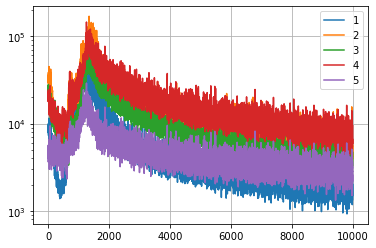

In [181]:
for i in range(samples_grads_1.shape[1]-5):
    plt.plot(samples_grads_1[10:,i], label=f"{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

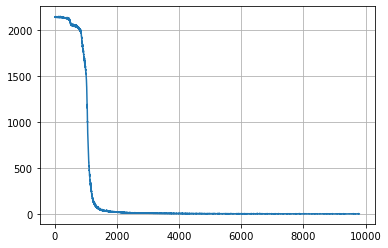

In [182]:
plt.plot(arr_total_loss_1[200:])
#plt.yscale('log')
#plt.ylim([2160,2220])
plt.grid()
plt.show()

In [183]:
pinn_2 = pinn.copy()
loss_stack_2 = [
    Observations(pinn_2,
                 inputs_obs = dataset['obs_input'],
                 outputs_obs = dataset['obs_output']),
         ASDM(pinn_2,
              inputs_pde = dataset['pde'],
              init_loss_weight = 10.0),
         #Periodic_boundary(pinn_2,
         #                 inputs_LB_boundary = dataset['boundary_LB'], 
         #                 inputs_RT_boundary = dataset['boundary_RT'])
        ]

In [187]:
model_2 = TINN(pinn_2, 
               loss_stack_2, 
               optimizer=keras.optimizers.SGD(learning_rate=1e-6),
               #optimizer=keras.optimizers.Adam(),
               fixed_pinn=True)
#model_1.optimizer.learning_rate=1e-4

In [188]:
arr_total_loss_2, arr_losses_2, samples_params_2 , samples_grads_2 = \
         model_2.train_experimental(5000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 10.0)

Epoch: 1, loss:5651.34
Loss_observations:1.65408675 
Loss_ASDM:5649.68304443 sigma_a:0:0.00000000, sigma_s:0:0.08595423, rho_a:0:1.22238684, rho_s:0:0.08147712, mu_a:0:1.27790833, kappa_a:0:0.20446855
Time:3.30

Epoch: 100, loss:5589.29
Loss_observations:1.65408678 
Loss_ASDM:5587.63510132 sigma_a:0:0.00000000, sigma_s:0:0.08626469, rho_a:0:1.28108644, rho_s:0:0.08254199, mu_a:0:1.32918966, kappa_a:0:0.21127185
Time:95.71

Epoch: 200, loss:5539.27
Loss_observations:1.65408675 
Loss_ASDM:5537.62017822 sigma_a:0:0.00000000, sigma_s:0:0.08654702, rho_a:0:1.33405328, rho_s:0:0.08345913, mu_a:0:1.37545180, kappa_a:0:0.21731575
Time:96.91

Epoch: 300, loss:5499.57
Loss_observations:1.65408678 
Loss_ASDM:5497.92083740 sigma_a:0:0.00000000, sigma_s:0:0.08684023, rho_a:0:1.38130414, rho_s:0:0.08417569, mu_a:0:1.41694140, kappa_a:0:0.22299102
Time:96.75

Epoch: 400, loss:5467.07
Loss_observations:1.65408675 
Loss_ASDM:5465.41687012 sigma_a:0:0.00000000, sigma_s:0:0.08707712, rho_a:0:1.42391455, 

Epoch: 3800, loss:5332.22
Loss_observations:1.65408676 
Loss_ASDM:5330.56890869 sigma_a:0:0.00082194, sigma_s:0:0.08859459, rho_a:0:1.80198526, rho_s:0:0.08993465, mu_a:0:1.77710080, kappa_a:0:0.26137948
Time:96.52

Epoch: 3900, loss:5331.17
Loss_observations:1.65408678 
Loss_ASDM:5329.51748657 sigma_a:0:0.00109946, sigma_s:0:0.08860171, rho_a:0:1.80325294, rho_s:0:0.08993392, mu_a:0:1.77854013, kappa_a:0:0.26126471
Time:96.75

Epoch: 4000, loss:5330.82
Loss_observations:1.65408675 
Loss_ASDM:5329.16857910 sigma_a:0:0.00153889, sigma_s:0:0.08858178, rho_a:0:1.80464232, rho_s:0:0.08995128, mu_a:0:1.77977824, kappa_a:0:0.26082027
Time:96.47

Epoch: 4100, loss:5331.72
Loss_observations:1.65408675 
Loss_ASDM:5330.06982422 sigma_a:0:0.00156758, sigma_s:0:0.08860804, rho_a:0:1.80552387, rho_s:0:0.08992250, mu_a:0:1.78144705, kappa_a:0:0.26143175
Time:96.50

Epoch: 4200, loss:5331.35
Loss_observations:1.65408676 
Loss_ASDM:5329.69708252 sigma_a:0:0.00172289, sigma_s:0:0.08862225, rho_a:0:1.80

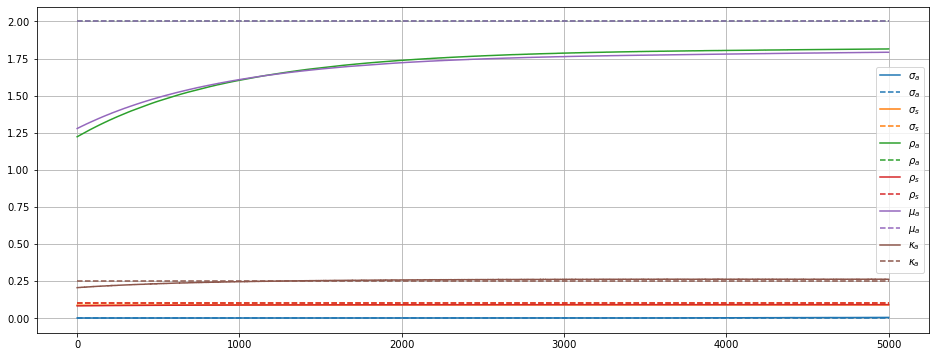

In [189]:
_ = plt.figure(figsize=(16,6))
#plt.subplot(1,2,1)
params_str = [r"$\sigma_a$", r"$\sigma_s$", r"$\rho_a$",r"$\rho_s$", "$\mu_a$", r"$\kappa_a$"]
params_val = [0, 0.02/0.2, 0.01/0.005,0.02/0.2, 0.01/0.005, 0.25]
for i, (label, val) in enumerate(zip(params_str, params_val)):
    l = plt.plot(samples_params_2[:,i], label=label)
    plt.hlines(val, 0, len(samples_params_2[:,i]), l[0].get_color(), linestyles='--', label=label)

plt.legend()
plt.grid()



In [195]:
model_2.trainable_vars()

(<tf.Variable 'sigma_a:0' shape=(1,) dtype=float32, numpy=array([0.00383012], dtype=float32)>,
 <tf.Variable 'sigma_s:0' shape=(1,) dtype=float32, numpy=array([0.08855136], dtype=float32)>,
 <tf.Variable 'rho_a:0' shape=(1,) dtype=float32, numpy=array([1.8148887], dtype=float32)>,
 <tf.Variable 'rho_s:0' shape=(1,) dtype=float32, numpy=array([0.08997885], dtype=float32)>,
 <tf.Variable 'mu_a:0' shape=(1,) dtype=float32, numpy=array([1.7921656], dtype=float32)>,
 <tf.Variable 'kappa_a:0' shape=(1,) dtype=float32, numpy=array([0.26057974], dtype=float32)>)

In [204]:
pinn_3 = pinn_2.copy()
loss_stack_3 = [
    Observations(pinn_3,
                 inputs_obs = dataset['obs_input'],
                 outputs_obs = dataset['obs_output']),
         ASDM(pinn_3,
              inputs_pde = dataset['pde'],
              init_loss_weight = 1.0,
              sigma_a = loss_stack_2[1].sigma_a.numpy()[0],
              sigma_s = loss_stack_2[1].sigma_s.numpy()[0],
              mu_a = loss_stack_2[1].mu_a.numpy()[0],
              rho_a = loss_stack_2[1].rho_a.numpy()[0],
              rho_s = loss_stack_2[1].rho_s.numpy()[0],
              kappa_a = loss_stack_2[1].kappa_a.numpy()[0])
         #Periodic_boundary(pinn_2,
         #                 inputs_LB_boundary = dataset['boundary_LB'], 
         #                 inputs_RT_boundary = dataset['boundary_RT'])
        ]

In [205]:
model_3 = TINN(pinn_3, 
               loss_stack_3, 
               #optimizer=keras.optimizers.SGD(learning_rate=1e-6),
               optimizer=keras.optimizers.Adam(),
               fixed_loss_params=True)

In [206]:
arr_total_loss_3, arr_losses_3, samples_params_3 , samples_grads_3 = \
         model_3.train_experimental(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 10.0)

Epoch: 1, loss:403.80
Loss_observations:55.98129341 
Loss_ASDM:347.81905556 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:6.71

Epoch: 100, loss:148.46
Loss_observations:61.04655743 
Loss_ASDM:87.41247320 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:139.60

Epoch: 200, loss:128.12
Loss_observations:56.33343816 
Loss_ASDM:71.78293371 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:143.63

Epoch: 300, loss:117.40
Loss_observations:54.51478553 
Loss_ASDM:62.88245392 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:146.71

Epoch: 400, loss:109.85
Loss_observations:53.08858538 
Loss_ASDM:56.76248479 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:

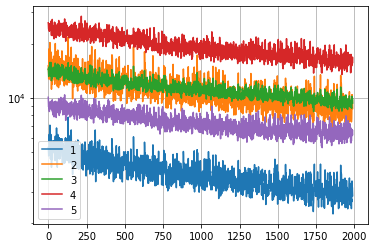

In [207]:
for i in range(samples_grads_3.shape[1]-5):
    plt.plot(samples_grads_3[10:,i], label=f"{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [227]:
arr_total_loss_3, arr_losses_3, samples_params_3 , samples_grads_3 = \
         model_3.train_experimental(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 10.0)

Epoch: 1, loss:61.14
Loss_observations:34.53116798 
Loss_ASDM:26.61225700 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:1.20

Epoch: 100, loss:59.53
Loss_observations:33.95996356 
Loss_ASDM:25.56832981 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:143.66

Epoch: 200, loss:59.06
Loss_observations:33.62329602 
Loss_ASDM:25.43342996 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:146.10

Epoch: 300, loss:59.30
Loss_observations:33.38409507 
Loss_ASDM:25.91720510 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:146.68

Epoch: 400, loss:55.43
Loss_observations:31.75208271 
Loss_ASDM:23.67310715 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08

In [ ]:
arr_total_loss_4, arr_losses_4, samples_params_4 , samples_grads_4 = \
         model_3.train_experimental(3000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 10.0)

Epoch: 1, loss:49.06
Loss_observations:27.87903249 
Loss_ASDM:21.18071795 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:1.17

Epoch: 100, loss:47.12
Loss_observations:27.25090706 
Loss_ASDM:19.87096083 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:144.30

Epoch: 200, loss:46.02
Loss_observations:26.61099446 
Loss_ASDM:19.40687859 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:146.11

Epoch: 300, loss:44.16
Loss_observations:25.65021634 
Loss_ASDM:18.51233649 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08997885, mu_a:0:1.79216564, kappa_a:0:0.26057974
Time:147.40

Epoch: 400, loss:43.77
Loss_observations:24.98619509 
Loss_ASDM:18.77883637 sigma_a:0:0.00383012, sigma_s:0:0.08855136, rho_a:0:1.81488872, rho_s:0:0.08

In [228]:
pinn_4 = pinn_3.copy()
loss_stack_4 = [
    Observations(pinn_4,
                 inputs_obs = dataset['obs_input'],
                 outputs_obs = dataset['obs_output']),
         ASDM(pinn_4,
              inputs_pde = dataset['pde'],
              init_loss_weight = 10.0,
              sigma_a = loss_stack_3[1].sigma_a.numpy()[0],
              sigma_s = loss_stack_3[1].sigma_s.numpy()[0],
              mu_a = loss_stack_3[1].mu_a.numpy()[0],
              rho_a = loss_stack_3[1].rho_a.numpy()[0],
              rho_s = loss_stack_3[1].rho_s.numpy()[0],
              kappa_a = loss_stack_3[1].kappa_a.numpy()[0]),
         #Periodic_boundary(pinn_2,
         #                 inputs_LB_boundary = dataset['boundary_LB'], 
         #                 inputs_RT_boundary = dataset['boundary_RT'])
        ]

In [229]:
model_4 = TINN(pinn_4, 
               loss_stack_4, 
               #optimizer=keras.optimizers.SGD(learning_rate=1e-5),
               optimizer=keras.optimizers.Adam(epsilon=1e-01),
               fixed_pinn=True)

In [230]:
arr_total_loss_4, arr_losses_4, samples_params_4 , samples_grads_4 = \
         model_4.train_experimental(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 10.0)

Epoch: 1, loss:243.15
Loss_observations:27.09007502 
Loss_ASDM:216.06118011 sigma_a:0:0.00000000, sigma_s:0:0.08232025, rho_a:0:1.81209171, rho_s:0:0.08184792, mu_a:0:1.79804754, kappa_a:0:0.25734162
Time:6.12

Epoch: 100, loss:228.25
Loss_observations:27.09007478 
Loss_ASDM:201.15551662 sigma_a:0:0.02052929, sigma_s:0:0.08140088, rho_a:0:1.88793874, rho_s:0:0.08053166, mu_a:0:1.90555561, kappa_a:0:0.25186878
Time:100.19

Epoch: 200, loss:227.55
Loss_observations:27.09007466 
Loss_ASDM:200.46031094 sigma_a:0:0.02564883, sigma_s:0:0.08104037, rho_a:0:1.90899932, rho_s:0:0.08069427, mu_a:0:1.93127751, kappa_a:0:0.25218678
Time:100.19

Epoch: 300, loss:227.80
Loss_observations:27.09007466 
Loss_ASDM:200.70945454 sigma_a:0:0.02588241, sigma_s:0:0.08143261, rho_a:0:1.91386235, rho_s:0:0.08099476, mu_a:0:1.93722320, kappa_a:0:0.25181597
Time:100.42

Epoch: 400, loss:227.58
Loss_observations:27.09007490 
Loss_ASDM:200.49374676 sigma_a:0:0.02669773, sigma_s:0:0.08094181, rho_a:0:1.91491210, rh

Exception ignored in: <function ScopedTFGraph.__del__ at 0x7fb5346fc1f0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/tensorflow.2.9/lib/python3.10/site-packages/tensorflow/python/framework/c_api_util.py", line 54, in __del__
    def __del__(self):
KeyboardInterrupt: 


Epoch: 700, loss:227.65
Loss_observations:27.09007514 
Loss_ASDM:200.56431103 sigma_a:0:0.02682936, sigma_s:0:0.08204965, rho_a:0:1.91522646, rho_s:0:0.08010037, mu_a:0:1.93895555, kappa_a:0:0.25206357
Time:101.66

Epoch: 800, loss:227.57
Loss_observations:27.09007490 
Loss_ASDM:200.48215961 sigma_a:0:0.02658398, sigma_s:0:0.08125234, rho_a:0:1.91516399, rho_s:0:0.08065531, mu_a:0:1.93902206, kappa_a:0:0.25206330
Time:103.44

Epoch: 900, loss:227.60
Loss_observations:27.09007478 
Loss_ASDM:200.50548267 sigma_a:0:0.02630722, sigma_s:0:0.08101062, rho_a:0:1.91494238, rho_s:0:0.08086503, mu_a:0:1.93926060, kappa_a:0:0.25211796
Time:101.55

Epoch: 1000, loss:227.73
Loss_observations:27.09007442 
Loss_ASDM:200.64003372 sigma_a:0:0.02671958, sigma_s:0:0.08123017, rho_a:0:1.91514409, rho_s:0:0.08069215, mu_a:0:1.93895984, kappa_a:0:0.25207552
Time:100.03



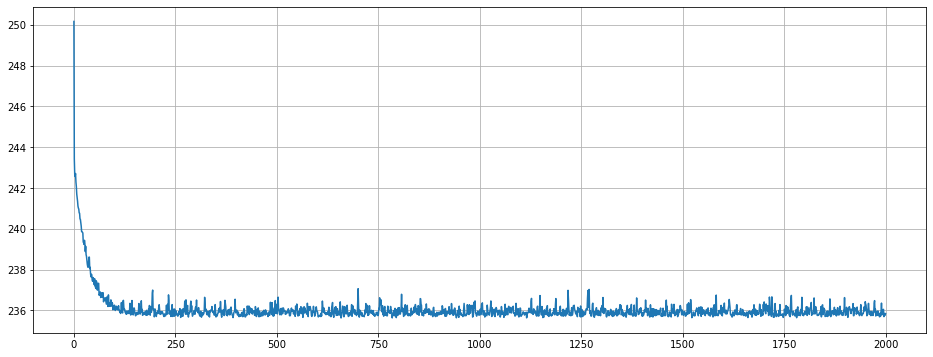

In [223]:
_ = plt.figure(figsize=(16,6))
plt.plot(arr_losses_4[:,1])
plt.grid()
plt.show()

In [224]:
pinn_5 = pinn_4.copy()
loss_stack_5 = [
    Observations(pinn_5,
                 inputs_obs = dataset['obs_input'],
                 outputs_obs = dataset['obs_output']),
         ASDM(pinn_5,
              inputs_pde = dataset['pde'],
              init_loss_weight = 10.0,
              sigma_a = loss_stack_4[1].sigma_a.numpy()[0],
              sigma_s = loss_stack_4[1].sigma_s.numpy()[0],
              mu_a = loss_stack_4[1].mu_a.numpy()[0],
              rho_a = loss_stack_4[1].rho_a.numpy()[0],
              rho_s = loss_stack_4[1].rho_s.numpy()[0],
              kappa_a = loss_stack_4[1].kappa_a.numpy()[0]),
         #Periodic_boundary(pinn_2,
         #                 inputs_LB_boundary = dataset['boundary_LB'], 
         #                 inputs_RT_boundary = dataset['boundary_RT'])
        ]

In [225]:
model_5 = TINN(pinn_5, 
               loss_stack_5, 
               #optimizer=keras.optimizers.SGD(learning_rate=1e-6),
               optimizer=keras.optimizers.Adam(),
               fixed_loss_params=True)

In [226]:
arr_total_loss_5, arr_losses_5, samples_params_5 , samples_grads_5 = \
         model_5.train_experimental(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 10.0)

Epoch: 1, loss:743.88
Loss_observations:65.59259748 
Loss_ASDM:678.28778648 sigma_a:0:0.02493437, sigma_s:0:0.07964360, rho_a:0:1.91132617, rho_s:0:0.07848435, mu_a:0:1.92869222, kappa_a:0:0.25316843
Time:6.58

Epoch: 100, loss:168.56
Loss_observations:62.52503562 
Loss_ASDM:106.03173494 sigma_a:0:0.02493437, sigma_s:0:0.07964360, rho_a:0:1.91132617, rho_s:0:0.07848435, mu_a:0:1.92869222, kappa_a:0:0.25316843
Time:142.45

Epoch: 200, loss:160.75
Loss_observations:65.66920519 
Loss_ASDM:95.07925081 sigma_a:0:0.02493437, sigma_s:0:0.07964360, rho_a:0:1.91132617, rho_s:0:0.07848435, mu_a:0:1.92869222, kappa_a:0:0.25316843
Time:144.64



KeyboardInterrupt: 

In [173]:
pinn = NN(layers, lb, ub)
losses = [Observations(pinn,
                       inputs_obs = dataset['obs_input'],
                       outputs_obs = dataset['obs_output']),
         ASDM(pinn,
                   inputs_pde = dataset['pde'],
                   init_loss_weight = 10.0)]

In [176]:
model = TINN(pinn, losses)

In [177]:
arr_total_loss, arr_losses, samples_params = \
         model.train(10,batch_size=dataset['obs_input'].shape[0]//16, print_iter=1)

Epoch: 1, loss:3234.78
Loss_observations:3183.08058167 
Loss_ASDM:51.69992161 sigma_a:0:0.80354589, sigma_s:0:0.64423090, rho_a:0:0.96257108, rho_s:0:1.04472077, mu_a:0:1.12295723, kappa_a:0:0.99897534
Time:1.47

Epoch: 2, loss:3161.24
Loss_observations:3110.41252136 
Loss_ASDM:50.82817221 sigma_a:0:0.79960221, sigma_s:0:0.64494723, rho_a:0:0.96013981, rho_s:0:1.04423201, mu_a:0:1.12779665, kappa_a:0:1.00069976
Time:0.11

Epoch: 3, loss:3092.81
Loss_observations:3044.40148926 
Loss_ASDM:48.41246438 sigma_a:0:0.79585582, sigma_s:0:0.64566183, rho_a:0:0.95782697, rho_s:0:1.04374373, mu_a:0:1.13236201, kappa_a:0:1.00234139
Time:0.10

Epoch: 4, loss:3029.13
Loss_observations:2981.52461243 
Loss_ASDM:47.60472822 sigma_a:0:0.79218471, sigma_s:0:0.64636827, rho_a:0:0.95555729, rho_s:0:1.04325986, mu_a:0:1.13680470, kappa_a:0:1.00394189
Time:0.10

Epoch: 5, loss:2969.73
Loss_observations:2923.65734863 
Loss_ASDM:46.07428694 sigma_a:0:0.78866130, sigma_s:0:0.64706463, rho_a:0:0.95337605, rho_s:

In [11]:
np.min(arr_total_loss)

2153.876708984375

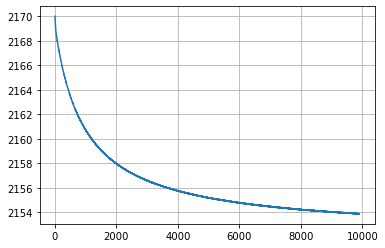

In [13]:
plt.plot(arr_total_loss[100:])
#plt.yscale('log')
#plt.ylim([2160,2220])
plt.grid()
plt.show()

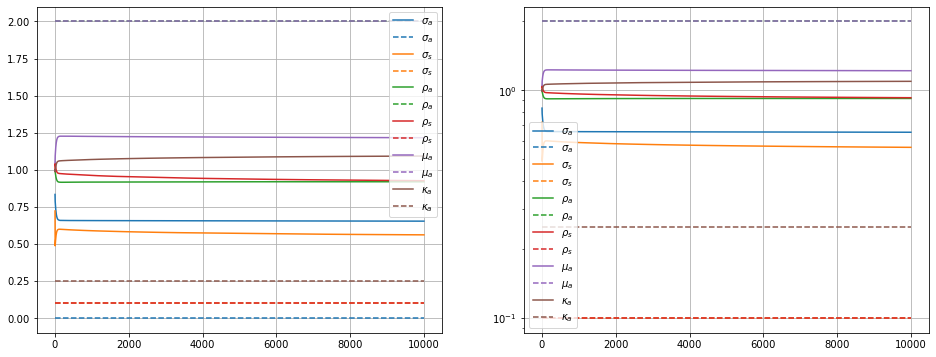

In [14]:
_ = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
params_str = [r"$\sigma_a$", r"$\sigma_s$", r"$\rho_a$",r"$\rho_s$", "$\mu_a$", r"$\kappa_a$"]
params_val = [0, 0.02/0.2, 0.01/0.005,0.02/0.2, 0.01/0.005, 0.25]
for i, (label, val) in enumerate(zip(params_str, params_val)):
    l = plt.plot(samples_params[:,i], label=label)
    plt.hlines(val, 0, len(samples_params[:,i]), l[0].get_color(), linestyles='--', label=label)

plt.legend()
plt.grid()

plt.subplot(1,2,2)
params_str = [r"$\sigma_a$", r"$\sigma_s$", r"$\rho_a$",r"$\rho_s$", "$\mu_a$", r"$\kappa_a$"]
for i, (label, val) in enumerate(zip(params_str, params_val)):
    l = plt.plot(samples_params[:,i], label=label)
    plt.hlines(val, 0, len(samples_params[:,i]), l[0].get_color(), linestyles='--', label=label)

plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

In [16]:
model.optimizer.learning_rate=1e-5

In [17]:
arr_total_loss2, arr_losses2, samples_params2 = \
         model.train(10000,batch_size=dataset['obs_input'].shape[0]//16, print_iter=100)

Epoch: 1, loss:2154.52
Loss_observations:2152.37094879 
Loss_ASDM:2.14424174 sigma_a:0:0.65317529, sigma_s:0:0.56069571, rho_a:0:0.91876203, rho_s:0:0.92571521, mu_a:0:1.21575928, kappa_a:0:1.09231377
Time:0.61

Epoch: 100, loss:2154.05
Loss_observations:2152.15915680 
Loss_ASDM:1.88813157 sigma_a:0:0.65235466, sigma_s:0:0.55930161, rho_a:0:0.91863900, rho_s:0:0.92404479, mu_a:0:1.21509421, kappa_a:0:1.09329104
Time:68.08

Epoch: 200, loss:2153.73
Loss_observations:2151.97589111 
Loss_ASDM:1.75820561 sigma_a:0:0.65185922, sigma_s:0:0.55825907, rho_a:0:0.91871494, rho_s:0:0.92236578, mu_a:0:1.21408629, kappa_a:0:1.09413970
Time:71.83

Epoch: 300, loss:2153.74
Loss_observations:2152.16110992 
Loss_ASDM:1.58206476 sigma_a:0:0.65128040, sigma_s:0:0.55716079, rho_a:0:0.91871780, rho_s:0:0.92092502, mu_a:0:1.21320593, kappa_a:0:1.09487987
Time:73.90

Epoch: 400, loss:2154.01
Loss_observations:2152.32486725 
Loss_ASDM:1.68699902 sigma_a:0:0.65089017, sigma_s:0:0.55636692, rho_a:0:0.91884512, 

Epoch: 3800, loss:2152.63
Loss_observations:2151.65422058 
Loss_ASDM:0.97979882 sigma_a:0:0.62487108, sigma_s:0:0.54122257, rho_a:0:0.91763759, rho_s:0:0.89735901, mu_a:0:1.18510616, kappa_a:0:1.10109818
Time:71.92

Epoch: 3900, loss:2152.73
Loss_observations:2151.69804382 
Loss_ASDM:1.03605043 sigma_a:0:0.62448323, sigma_s:0:0.54115307, rho_a:0:0.91793877, rho_s:0:0.89682502, mu_a:0:1.18375766, kappa_a:0:1.10097504
Time:72.88

Epoch: 4000, loss:2152.75
Loss_observations:2151.70601654 
Loss_ASDM:1.04890328 sigma_a:0:0.62318540, sigma_s:0:0.54071873, rho_a:0:0.91769928, rho_s:0:0.89651388, mu_a:0:1.18329823, kappa_a:0:1.10098457
Time:74.07

Epoch: 4100, loss:2152.60
Loss_observations:2151.56048584 
Loss_ASDM:1.03857083 sigma_a:0:0.62237537, sigma_s:0:0.54054874, rho_a:0:0.91775954, rho_s:0:0.89604712, mu_a:0:1.18234241, kappa_a:0:1.10093141
Time:69.97

Epoch: 4200, loss:2152.55
Loss_observations:2151.52123260 
Loss_ASDM:1.03076445 sigma_a:0:0.62159407, sigma_s:0:0.54039139, rho_a:0:0.91

Epoch: 7600, loss:2152.21
Loss_observations:2151.04772186 
Loss_ASDM:1.16442119 sigma_a:0:0.58493501, sigma_s:0:0.53222108, rho_a:0:0.92039454, rho_s:0:0.88011909, mu_a:0:1.14646637, kappa_a:0:1.09693122
Time:70.70

Epoch: 7700, loss:2152.13
Loss_observations:2150.99456024 
Loss_ASDM:1.13796953 sigma_a:0:0.58331305, sigma_s:0:0.53175712, rho_a:0:0.92032158, rho_s:0:0.87971622, mu_a:0:1.14562702, kappa_a:0:1.09681463
Time:72.26

Epoch: 7800, loss:2152.38
Loss_observations:2151.01309204 
Loss_ASDM:1.36194427 sigma_a:0:0.58222890, sigma_s:0:0.53157490, rho_a:0:0.92058510, rho_s:0:0.87913501, mu_a:0:1.14422846, kappa_a:0:1.09662437
Time:69.90

Epoch: 7900, loss:2152.15
Loss_observations:2150.86105347 
Loss_ASDM:1.28718787 sigma_a:0:0.58060271, sigma_s:0:0.53113967, rho_a:0:0.92054462, rho_s:0:0.87869060, mu_a:0:1.14332008, kappa_a:0:1.09650350
Time:74.50

Epoch: 8000, loss:2152.09
Loss_observations:2150.91378021 
Loss_ASDM:1.17213493 sigma_a:0:0.57938516, sigma_s:0:0.53091341, rho_a:0:0.92

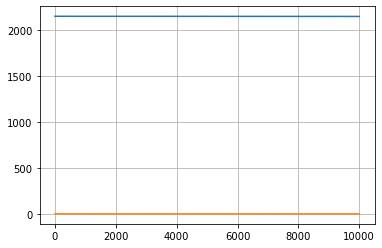

In [18]:
plt.plot(arr_losses2[:,0])
plt.plot(arr_losses2[:,1])
plt.grid()
plt.show()

In [19]:
model.optimizer.learning_rate=1e-4

In [20]:
arr_total_loss3, arr_losses3 = model.train(5000,batch_size=dataset['obs_input'].shape[0]//16, print_iter=100)

Epoch: 1, loss:nan
Loss_observations:nan 
Loss_ASDM:nan sigma_a:0:nan, sigma_s:0:nan, rho_a:0:nan, rho_s:0:nan, mu_a:0:nan, kappa_a:0:nan
Time:0.64

Epoch: 100, loss:nan
Loss_observations:nan 
Loss_ASDM:nan sigma_a:0:nan, sigma_s:0:nan, rho_a:0:nan, rho_s:0:nan, mu_a:0:nan, kappa_a:0:nan
Time:73.60

Epoch: 200, loss:nan
Loss_observations:nan 
Loss_ASDM:nan sigma_a:0:nan, sigma_s:0:nan, rho_a:0:nan, rho_s:0:nan, mu_a:0:nan, kappa_a:0:nan
Time:73.47

Epoch: 300, loss:nan
Loss_observations:nan 
Loss_ASDM:nan sigma_a:0:nan, sigma_s:0:nan, rho_a:0:nan, rho_s:0:nan, mu_a:0:nan, kappa_a:0:nan
Time:74.73

Epoch: 400, loss:nan
Loss_observations:nan 
Loss_ASDM:nan sigma_a:0:nan, sigma_s:0:nan, rho_a:0:nan, rho_s:0:nan, mu_a:0:nan, kappa_a:0:nan
Time:73.80

Epoch: 500, loss:nan
Loss_observations:nan 
Loss_ASDM:nan sigma_a:0:nan, sigma_s:0:nan, rho_a:0:nan, rho_s:0:nan, mu_a:0:nan, kappa_a:0:nan
Time:70.93

Epoch: 600, loss:nan
Loss_observations:nan 
Loss_ASDM:nan sigma_a:0:nan, sigma_s:0:nan, rho

KeyboardInterrupt: 

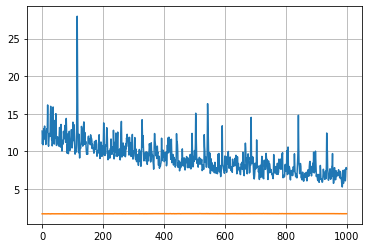

In [122]:
plt.plot(arr_losses3[:,0])
plt.plot(arr_losses3[:,1])
plt.grid()
plt.show()

In [12]:
losses2 = [Observations(pinn,
                       inputs_obs = dataset['obs_input'],
                       outputs_obs = dataset['obs_output']),
         ASDM(pinn,
              inputs_pde = dataset['pde'])]

In [13]:
model2 = TINN(pinn, losses2)

In [ ]:
arr_total_loss2, arr_losses2 = model2.train(2500,batch_size=dataset['obs_input'].shape[0]//16, print_iter=100)

Epoch: 0, loss:6979.18
Loss_observations:1762.46422001 
Loss_ASDM:5216.71612945 sigma_a:0:0.01471459, sigma_s:0:0.98686856, mu_a:0:0.98503473, rho_a:0:1.01547943, rho_s:0:1.01214941, kappa_a:0:0.98516913
Time:2.21

Epoch: 100, loss:935.61
Loss_observations:144.45281579 
Loss_ASDM:791.16068026 sigma_a:0:0.00000000, sigma_s:0:0.21567939, mu_a:0:0.74871035, rho_a:0:1.23633183, rho_s:0:0.31489502, kappa_a:0:0.72793854
Time:67.43

Epoch: 200, loss:146149.06
Loss_observations:4360.40472597 
Loss_ASDM:141788.65547742 sigma_a:0:0.04438227, sigma_s:0:0.00009256, mu_a:0:1.58868551, rho_a:0:1.23908631, rho_s:0:0.00000000, kappa_a:0:0.03624755
Time:68.82

Epoch: 300, loss:4924.03
Loss_observations:2219.34335111 
Loss_ASDM:2704.68954908 sigma_a:0:0.03308811, sigma_s:0:0.00000000, mu_a:0:1.68219040, rho_a:0:1.27596690, rho_s:0:0.00000000, kappa_a:0:0.00451555
Time:69.10

Epoch: 400, loss:2823.58
Loss_observations:2190.28719191 
Loss_ASDM:633.29591936 sigma_a:0:0.10299455, sigma_s:0:0.00000000, mu_a:

Exception ignored in: <function ScopedTFGraph.__del__ at 0x7fe7252b41f0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/tensorflow.2.9/lib/python3.10/site-packages/tensorflow/python/framework/c_api_util.py", line 54, in __del__
    def __del__(self):
KeyboardInterrupt: 


In [6]:
pinn = NN(layers, lb, ub)
losses = [Observations(pinn,
                       inputs_obs = dataset['obs_input'],
                       outputs_obs = dataset['obs_output']),
         ASDM(pinn,
              inputs_pde = dataset['pde']),
         Periodic_boundary(pinn,
                          inputs_LB_boundary = dataset['boundary_LB'], 
                          inputs_RT_boundary = dataset['boundary_RT'])]

2022-06-15 23:38:55.673947: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-15 23:38:55.674106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ld-rendres10
2022-06-15 23:38:55.674157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ld-rendres10
2022-06-15 23:38:55.674422: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.33.1
2022-06-15 23:38:55.675024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.33.1
2022-06-15 23:38:55.675064: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.33.1


In [7]:
model = TINN(pinn, losses)

In [8]:
arr_total_loss, arr_losses = model.train(10000,batch_size=dataset['obs_input'].shape[0]//16, print_iter=100)

Epoch: 0, loss:32641.22
Loss_observations:16489.17861219 
Loss_ASDM:16101.15748963 sigma_a:0:0.01448750, sigma_s:0:0.98407180, mu_a:0:0.98463672, rho_a:0:1.00890261, rho_s:0:1.01140682, kappa_a:0:0.99041854
Loss_Periodic_Boundary:50.88548204 
Time:3.05

Epoch: 100, loss:2178.93
Loss_observations:2172.12510663 
Loss_ASDM:4.09576045 sigma_a:0:0.09233201, sigma_s:0:0.87929102, mu_a:0:0.88909631, rho_a:0:1.11130567, rho_s:0:1.23194023, kappa_a:0:0.77563576
Loss_Periodic_Boundary:2.71272519 
Time:74.20

Epoch: 200, loss:2176.28
Loss_observations:2172.90954973 
Loss_ASDM:2.39617932 sigma_a:0:0.09392095, sigma_s:0:0.87348283, mu_a:0:0.88391645, rho_a:0:1.10858258, rho_s:0:1.22989083, kappa_a:0:0.78531892
Loss_Periodic_Boundary:0.97052986 
Time:77.35

Epoch: 300, loss:2176.73
Loss_observations:2172.49053519 
Loss_ASDM:2.56143035 sigma_a:0:0.09518357, sigma_s:0:0.86281057, mu_a:0:0.87785105, rho_a:0:1.10386036, rho_s:0:1.22704974, kappa_a:0:0.79998014
Loss_Periodic_Boundary:1.67360515 
Time:76.

Epoch: 3300, loss:2170.44
Loss_observations:2167.56991753 
Loss_ASDM:1.21459880 sigma_a:0:0.00298860, sigma_s:0:0.43880691, mu_a:0:0.60229013, rho_a:0:1.11928837, rho_s:0:0.82703604, kappa_a:0:1.37890494
Loss_Periodic_Boundary:1.65909246 
Time:82.42

Epoch: 3400, loss:2169.17
Loss_observations:2166.80054485 
Loss_ASDM:0.72916810 sigma_a:0:0.00196960, sigma_s:0:0.42312855, mu_a:0:0.59315153, rho_a:0:1.11617056, rho_s:0:0.79940218, kappa_a:0:1.40399551
Loss_Periodic_Boundary:1.64254113 
Time:78.69

Epoch: 3500, loss:2168.96
Loss_observations:2166.56942117 
Loss_ASDM:0.86323400 sigma_a:0:0.00302076, sigma_s:0:0.40389461, mu_a:0:0.58343330, rho_a:0:1.11208830, rho_s:0:0.77210996, kappa_a:0:1.42765210
Loss_Periodic_Boundary:1.52652853 
Time:83.38

Epoch: 3600, loss:2170.96
Loss_observations:2168.29919737 
Loss_ASDM:1.12892449 sigma_a:0:0.00039411, sigma_s:0:0.38403923, mu_a:0:0.57931394, rho_a:0:1.10316008, rho_s:0:0.74699154, kappa_a:0:1.45335147
Loss_Periodic_Boundary:1.52908740 
Time:84.

Epoch: 6600, loss:2164.01
Loss_observations:1377.27098482 
Loss_ASDM:747.25450067 sigma_a:0:0.04897581, sigma_s:0:0.05990584, mu_a:0:1.19355728, rho_a:0:0.87583956, rho_s:0:0.04586176, kappa_a:0:0.01245480
Loss_Periodic_Boundary:39.48901172 
Time:82.51

Epoch: 6700, loss:346273.89
Loss_observations:10163.06188467 
Loss_ASDM:333733.19391785 sigma_a:0:0.00438355, sigma_s:0:0.00073469, mu_a:0:1.33002651, rho_a:0:1.01844041, rho_s:0:0.00000000, kappa_a:0:0.00000000
Loss_Periodic_Boundary:2377.63032480 
Time:84.11

Epoch: 6800, loss:70149.31
Loss_observations:2997.73936604 
Loss_ASDM:66359.65598942 sigma_a:0:0.00000000, sigma_s:0:0.00000000, mu_a:0:1.55266070, rho_a:0:1.11324916, rho_s:0:0.00000000, kappa_a:0:0.00215328
Loss_Periodic_Boundary:791.91151303 
Time:84.81

Epoch: 6900, loss:37792.97
Loss_observations:2643.29680428 
Loss_ASDM:34936.13793309 sigma_a:0:0.04259549, sigma_s:0:0.00000000, mu_a:0:1.72944311, rho_a:0:1.18386863, rho_s:0:0.00000000, kappa_a:0:0.00000000
Loss_Periodic_Bou

Epoch: 9800, loss:3841.93
Loss_observations:2172.97031573 
Loss_ASDM:1615.01212843 sigma_a:0:0.00006652, sigma_s:0:0.17161176, mu_a:0:3.37690166, rho_a:0:2.67694682, rho_s:0:0.13709260, kappa_a:0:0.00188837
Loss_Periodic_Boundary:53.94960096 
Time:87.28

Epoch: 9900, loss:2994.58
Loss_observations:2171.70533151 
Loss_ASDM:769.48581521 sigma_a:0:0.00763921, sigma_s:0:0.25266195, mu_a:0:3.38709011, rho_a:0:2.66912509, rho_s:0:0.20054547, kappa_a:0:0.00224929
Loss_Periodic_Boundary:53.38994300 
Time:88.47



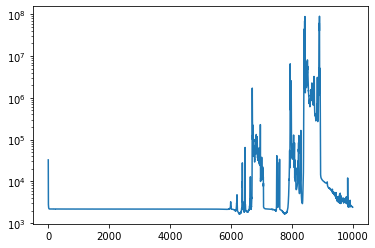

In [10]:
plt.plot(arr_total_loss)
plt.yscale('log')
plt.show()

In [252]:
layers = [3, 10, 10, 10, 2]
sample_xyt  = np.array([ [0, 0, 0],
                         [0, 1, 0],
                         [1, 0, 0],
                         [1, 1, 0],
                         [0, 0, 1],
                         [0, 1, 1],
                         [1, 0, 1],
                         [1, 1, 1],
                         [0, 0, 2],
                         [0, 1, 2],
                         [1, 0, 2],
                         [1, 1, 2]
                       ])

lb, ub = lower_upper_bounds([sample_xyt])
#print(normalise_inputs([sample_xyt, sample_xyt.copy()*2]))

model = NN(layers, lb, ub)

In [255]:
#from tensorflow.python.framework.ops import disable_eager_execution

#disable_eager_execution()
i = tf.constant(sample_xyt*1.0)
#o, p1, p2 = model(i, True)
o = model(i, False)

In [259]:
model.trainable_weights == model.trainable_variables

True

In [114]:
dataset.keys()

dict_keys(['obs_input', 'obs_output', 'pde', 'boundary_LB', 'boundary_TR'])

In [108]:
T*16

8192

In [115]:
dataset['boundary_LB'].shape

(4096, 3)

In [69]:
asdm = ASDM(layers, 
           inputs_obs = np.c_[dataset['x_obs'], dataset['y_obs'], dataset['t_obs']],
           output_obs = np.c_[dataset['a_obs'], dataset['s_obs']]
            )

In [70]:
asdm.train(400, T*4, print_iter=100)

Epoch: 0, loss:35680.41, 
Time:1.70

Epoch: 100, loss:2178.56, 
Time:6.64

Epoch: 200, loss:2176.05, 
Time:6.57

Epoch: 300, loss:2176.39, 
Time:6.57



In [71]:
asdm.model_vars()

[<tf.Variable 'sigma_a:0' shape=(1,) dtype=float64, numpy=array([0.10185468])>,
 <tf.Variable 'sigma_s:0' shape=(1,) dtype=float64, numpy=array([0.83944022])>,
 <tf.Variable 'mu_a:0' shape=(1,) dtype=float64, numpy=array([0.88263012])>,
 <tf.Variable 'rho_a:0' shape=(1,) dtype=float64, numpy=array([1.12305397])>,
 <tf.Variable 'rho_s:0' shape=(1,) dtype=float64, numpy=array([1.19049248])>,
 <tf.Variable 'kappa_a:0' shape=(1,) dtype=float64, numpy=array([0.82351467])>]

In [ ]:
class TINN2():
    """Turing-Informed Neoral Net"""
    def __init__(self, 
                 layers, 
                 inputs_obs,
                 output_obs,
                 inputs_pde = None,
                 boundary_spec = dict(
                    inputs_boundary = None,
                    boundary_loss_callback = None,
                    needs_grad = False 
                   )                 
                 ):
        self.model = NN(layers)
        self.inputs_obs = inputs_obs
        self.output_obs = output_obs        
        # Use the observation points for validating
        # PDE
        if inputs_pde is None:
            self.inputs_pde = inputs_obs
        else:
            self.inputs_pde = inputs_pde
            
        self.boundary_spec = boundary_spec
        if boundary_spec['inputs_boundary'] is None:
            self.has_bounday = False
        else:
            self.has_bounday = True
        if self.boundary_spec['boundary_loss_callback'] is None:
            self.boundary_loss_callback = self.periodic_boundary
        else:
            self.boundary_loss_callback = self.boundary_spec['boundary_loss_callback']        
        
        self.optimizer_Adam = keras.optimizers.Adam()
        #self.optimizer_Adam = tf.train.AdamOptimizer()
        #self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
     
    def periodic_boundary(self, inputs, boundary_pred, boundary_spec):        
        pass
    
    def pde_residuals(self, pde_inputs, pde_outputs, partials_1, partials_2):
        pass
    
    def model_vars(self):
        return []
    
    def loss_obs(self, inputs, outputs):
        obs_pred = self.model(inputs, grads = False)
        L = tf.reduce_sum(tf.square(obs_pred - outputs), name = "Loss_observations")
        return L
    
    def loss_pde(self, inputs):
        pde_outputs, partials_1, partials_2 = self.model(inputs, grads = True)
        pde_res = self.pde_residuals(inputs, pde_outputs, partials_1, partials_2)
        L = tf.reduce_sum(tf.square(pde_res), name = "Loss_pde")
        return L
        
    def loss_boundary(self, inputs, outputs):
        boundary_pred = self.model(inputs, self.boundary_spec['needs_grad'])        
        L = self.boundary_loss_callback(inputs, boundary_pred, self.boundary_spec)        
        return L
        
    
        
    def __batches__(self, batch_size):
        """Generator that returned shuffled indeces for each batch"""
        
        flg_boundary = self.has_bounday
        # Observation batch info 
        obs_n = self.inputs_obs.shape[0]
        batch_steps = obs_n//batch_size
        batch_steps = batch_steps + (obs_n-1)//(batch_steps*batch_size)
        # PDE batch info
        pde_n = self.inputs_pde.shape[0]
        pde_batch_size = pde_n//batch_steps        
        # Boundary condition batch info
        if flg_boundary:
            boundary_n = self.boundary_spec.inputs_boundary.shape[0]        
            boundary_batch_size = boundary_n//batch_steps
        # Observation indices   
        indices_obs = np.array(list(range(obs_n)))
        np.random.shuffle(indices_obs)
        # PDE  indices
        indices_pde = np.array(list(range(pde_n)))        
        np.random.shuffle(indices_pde)
        # Boundary condition  indices
        if flg_boundary:
            indices_boundary = np.array(list(range(boundary_n)))
            np.random.shuffle(indices_boundary)
            
        for batch in range(batch_steps):
            # Observation start-end
            obs_start = batch*batch_size
            obs_end = (batch+1)*batch_size
            obs_end = obs_end - (obs_end//obs_n)*(obs_end%obs_n)
            # PDE  start-end
            pde_start = batch*pde_batch_size
            pde_end = (batch+1)*pde_batch_size            
            # Boundary condition  start-end
            if flg_boundary:
                boundary_start = batch*boundary_batch_size
                boundary_end = (batch+1)*boundary_batch_size
                
            # Correction for PDE and boundary batches at last step
            if batch == batch_steps-1:
                if pde_end < pde_n:
                    pde_end = pde_n
                        
                if flg_boundary and boundary_end < boundary_n:
                    boundary_end = boundary_n
            # step's indices        
            batch_indices_obs = indices_obs[obs_start:obs_end]
            batch_indices_pde = indices_pde[pde_start:pde_end]
            if flg_boundary:
                batch_indices_boundary = indices_boundary[boundary_start:boundary_end]
                yield (batch_indices_obs, batch_indices_pde, batch_indices_boundary)
            else:
                yield (batch_indices_obs, batch_indices_pde, None)
        
    def train(self, epochs, batch_size, print_iter=10):
        start_time = time.time()
        for epoch in range(epochs):
            total_loss = 0            
            for obs_indeces, pde_indeces, boundary_indices in self.__batches__(batch_size):                
                obs_inputs_batch  = self.inputs_obs[obs_indeces]
                obs_outputs_batch = self.output_obs[obs_indeces]
                pde_inputs_batch  = self.inputs_pde[pde_indeces] 
                if self.has_bounday:
                    boundary_inputs_batch = self.boundary_spec.inputs_boundary[boundary_indices]
                    L = self.train_step(obs_inputs_batch, 
                                        obs_outputs_batch, 
                                        pde_inputs_batch,
                                        boundary_inputs_batch)
                else:
                    L = self.train_step(obs_inputs_batch, 
                                        obs_outputs_batch, 
                                        pde_inputs_batch,
                                        None)
                total_loss += L
                
            if epoch % print_iter == 0:
                elapsed = time.time() - start_time                                                                
                print(f"Epoch: {epoch}, loss:{total_loss:.2f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
    
    @tf.function
    def train_step(self, 
                   obs_inputs_batch, 
                   obs_outputs_batch, 
                   pde_inputs_batch,
                   boundary_inputs_batch):
        
        with tf.GradientTape() as tape:
            loss_obs = self.loss_obs(obs_inputs_batch, obs_outputs_batch)
            loss_pde = self.loss_pde(pde_inputs_batch)
                    
            loss = loss_obs + loss_pde
            if self.has_bounday:
                loss += self.loss_boundary(boundary_inputs_batch)
                
        
        trainable_vars = self.model.trainable_weights + self.model_vars()
        grads = tape.gradient(loss,  trainable_vars)
        self.optimizer_Adam.apply_gradients(zip(grads, trainable_vars))        
        return loss
        

class ASDM2(TINN):
    def __init__(self,
                 *arg,
                 **kwargs):
        super().__init__(*arg, **kwargs)
        
        
        self.sigma_a = tf.Variable([0.0], dtype=tf.float64,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.sigma_s = tf.Variable([1.00], dtype=tf.float64, 
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.mu_a = tf.Variable([1.00], dtype=tf.float64, 
                                name="mu_a",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_a = tf.Variable([1.00], dtype=tf.float64, 
                                 name="rho_a",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_s = tf.Variable([1.00], dtype=tf.float64, 
                                 name="rho_s",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.kappa_a = tf.Variable([1.00], dtype=tf.float64,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    def model_vars(self):
        return [self.sigma_a,
                self.sigma_s,
                self.mu_a,
                self.rho_a,
                self.rho_s,
                self.kappa_a
               ]
    
    def pde_residuals(self, pde_inputs, pde_outputs, partials_1, partials_2):    
        
        a = pde_outputs[:, 0]
        s = pde_outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float64)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a,axis=1), 
                          tf.expand_dims(f_s,axis=1),], axis = 1)